In [1]:
import dask_ml
dask_ml.__file__

'/Users/scott/Developer/stsievert/dask-ml/dask_ml/__init__.py'

In [2]:
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:57810 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


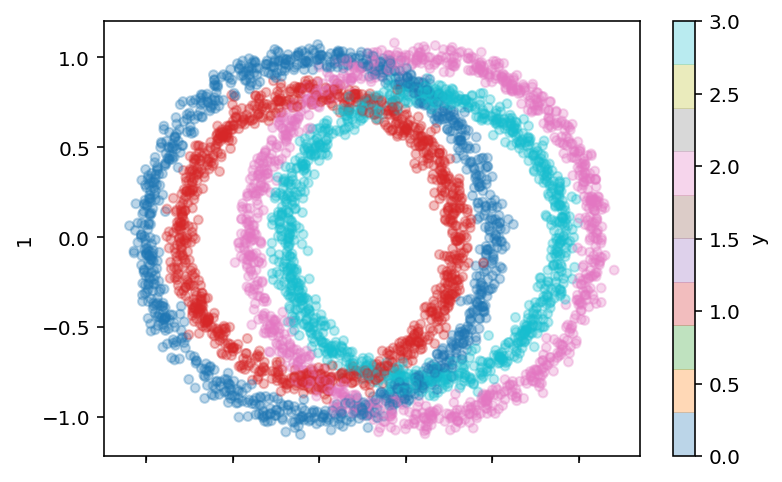

In [3]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd

X1, y1 = make_circles(n_samples=30_000, random_state=0, noise=0.04)
X2, y2 = make_circles(n_samples=30_000, random_state=1, noise=0.04)
X2[:, 0] += 0.6
X_info = np.concatenate((X1, X2))
y = np.concatenate((y1, y2 + 2))

df = pd.DataFrame(X_info)
df["y"] = y
df.sample(4_000).plot.scatter(x=0, y=1, c="y", cmap="tab10", alpha=0.3)


In [5]:
# add random features

from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_random_state

rng = check_random_state(42)
random_feats = rng.uniform(-1, 1, size=(X_info.shape[0], 4))
X_ = np.hstack((X_info, random_feats))

X = X_
# transform = PolynomialFeatures(degree=4)
# X = transform.fit_transform(X_)
X.shape

(60000, 6)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10_000, random_state=42)

In [7]:
import numpy as np
assert np.unique(y).tolist() == [0, 1, 2, 3]

In [8]:
X_test.shape

(10000, 6)

Let's normalize the data as in https://github.com/zalandoresearch/fashion-mnist/blob/629abc0f9a73c2897383a9178e8e38f7141be30d/benchmark/runner.py#L40-L44

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from dask_ml.model_selection import HyperbandSearchCV

/Users/scott/anaconda3/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [11]:
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

params = {
    "hidden_layer_sizes": [(24, ),
                           (12, ) * 2,
                           (6, ) * 4,
                           (4, ) * 6,
                           (12, 6, 3, 3)],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [32, 64, 128, 256, 512],  # 5
    "learning_rate": ["constant", "invscaling"],
    "learning_rate_init": np.logspace(-4, -2, num=1000), # cnts
    "power_t": np.linspace(0.1, 0.9, num=1000), # cnts
    "momentum": np.linspace(0, 1, num=1000),  # cnts
    "nesterovs_momentum": [True],  # 1
    "n_iter_no_change": [np.inf],
    "solver": ["sgd"],
    "activation": ["relu"],
}

This is `1 * 6 * 3 = 18` discrete combinations. There are 2 or 3 continious variables to tune.

In [12]:
X_train.shape, y_train.shape

((50000, 6), (50000,))

Let's train for 30 epochs and sample 180 parameters (10 parameters for every discrete combo). According to the documentation, that means each chunk should be 1/6 of the dataset.

In [12]:
epochs = 80
n_params = 300

n = len(X_train)
max_iter = n_params
chunks = epochs * n // n_params
max_iter, chunks

(300, 13333)

In [13]:
from dask_ml.model_selection import train_test_split
import dask.array as da
X_train = da.from_array(X_train, chunks=chunks)
y_train = da.from_array(y_train, chunks=chunks)
X_train

dask.array<array, shape=(50000, 6), dtype=float64, chunksize=(13333, 6)>

In [14]:
X_train.chunks

((13333, 13333, 13333, 10001), (6,))

In [15]:
classes = da.unique(y_train).compute()
print(classes)
y_train

[0 1 2 3]


dask.array<array, shape=(50000,), dtype=int64, chunksize=(13333,)>

In [16]:
import warnings
def fit_hyperband(model, params, max_iter=None, random_state=None):
    search = HyperbandSearchCV(
        model,
        params,
        max_iter=max_iter,
        random_state=random_state,
        patience=2,
        tol=np.nan,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        search.fit(X_train, y_train, classes=classes)
    print(pd.DataFrame(search.history_)["partial_fit_calls"].max())
    assert pd.DataFrame(search.history_)["partial_fit_calls"].max() == max_iter
    return search

N = 25
searches = {"hyperband": [], "passive": []}

In [17]:
from time import time
for k in range(N):
    print(f"Starting {k}...", end="")
    start = time()
    search = fit_hyperband(model, params, max_iter=max_iter, random_state=k)
    print(f"   done in {time() - start:2f} seconds")
    searches["hyperband"].append(search)

Starting 0...300
   done in 508.154139 seconds
Starting 1...300
   done in 610.463739 seconds
Starting 2...300
   done in 445.527151 seconds
Starting 3...300
   done in 500.779152 seconds
Starting 4...300
   done in 609.502598 seconds
Starting 5...300
   done in 450.633221 seconds
Starting 6...300
   done in 429.779354 seconds
Starting 7...300
   done in 482.975620 seconds
Starting 8...300
   done in 562.561594 seconds
Starting 9...300
   done in 473.395173 seconds
Starting 10...300
   done in 464.084496 seconds
Starting 11...300
   done in 410.111355 seconds
Starting 12...300
   done in 521.271524 seconds
Starting 13...300
   done in 530.922751 seconds
Starting 14...300
   done in 461.618326 seconds
Starting 15...300
   done in 472.248138 seconds
Starting 16...300
   done in 520.172256 seconds
Starting 17...300
   done in 543.071017 seconds
Starting 18...300
   done in 351.953619 seconds
Starting 19...300
   done in 446.370806 seconds
Starting 20...300
   done in 424.290777 seconds
St

In [18]:
total_calls = searches["hyperband"][0].metadata["partial_fit_calls"]

# total_calls = n_init * one_model
# set n_init = calls / one_model
n_init = total_calls / max_iter
total_calls, n_init

(7928, 26.426666666666666)

In [19]:
from dask_ml.model_selection import IncrementalSearchCV

def fit_passive(model, params, n_initial_params=None, max_iter=None, random_state=None):
    passive = IncrementalSearchCV(
        model,
        params,
        decay_rate=0,
        n_initial_parameters=n_init,
        max_iter=max_iter,
        random_state=random_state,
    )

    passive.fit(X_train, y_train, classes=classes)
    assert pd.DataFrame(passive.history_)["partial_fit_calls"].max() == max_iter
    return passive

In [20]:
for k in range(N):
    print(f"Starting {k}...", end="")
    start = time()
    search = fit_passive(
        model,
        params,
        max_iter=max_iter,
        n_initial_params=n_init,
        random_state=k
    )
    print(f"   done in {time() - start:2f} seconds")
    searches["passive"].append(search)

Starting 0...   done in 329.062627 seconds
Starting 1...   done in 394.379822 seconds
Starting 2...   done in 381.234866 seconds
Starting 3...   done in 540.939937 seconds
Starting 4...   done in 441.913258 seconds
Starting 5...   done in 375.984554 seconds
Starting 6...   done in 473.111415 seconds
Starting 7...   done in 405.043418 seconds
Starting 8...   done in 400.393884 seconds
Starting 9...   done in 374.459020 seconds
Starting 10...   done in 362.790882 seconds
Starting 11...   done in 375.278621 seconds
Starting 12...   done in 435.505044 seconds
Starting 13...   done in 396.475884 seconds
Starting 14...   done in 339.555032 seconds
Starting 15...   done in 343.043172 seconds
Starting 16...   done in 359.947614 seconds
Starting 17...   done in 394.471964 seconds
Starting 18...   done in 344.166231 seconds
Starting 19...   done in 327.243729 seconds
Starting 20...   done in 351.678200 seconds
Starting 21...   done in 360.561312 seconds
Starting 22...   done in 540.221376 second

In [21]:
import msgpack
today = "2019-06-22"

def _get_history(search):
    params = {k: v for k, v in search.get_params().items()
              if "estimator" not in k and k != "parameters"
    }
    out = [{**params, **h} for h in search.history_]
    return out

histories = {k: [_get_history(search) for search in alg_searches] for k, alg_searches in searches.items()}
with open(f"out/{today}-histories-2.msgpack", "wb") as f:
    msgpack.dump(histories, f)

best_scores = [
    {"score": search.best_score_, "alg": alg}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

params = [
    {"alg": alg, **search.best_params_}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

# models = {k: [search.best_estimator_ for search in alg_searches] for k, alg_searches in searches.items()}
# with open(f"out/{today}-models.msgpack", "wb") as f:
#     msgpack.dump(models, f)

pd.DataFrame(best_scores).to_csv(f"out/{today}-best-scores.csv", index=False)
pd.DataFrame(params).to_csv(f"out/{today}-best-params.csv", index=False)

In [22]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 **kwargs}]
    return out

In [23]:
import pandas as pd

histories = [
    shape_history(search.history_, alg=alg_name, random_state=search.random_state)
    for alg_name, alg_searches in searches.items()
    for search in alg_searches
]

df = pd.DataFrame(sum(histories, []))
df.head(n=2)

,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,random_state
0,hyperband,0.257948,1,0.000000,0
1,hyperband,0.265547,2,0.000003,0


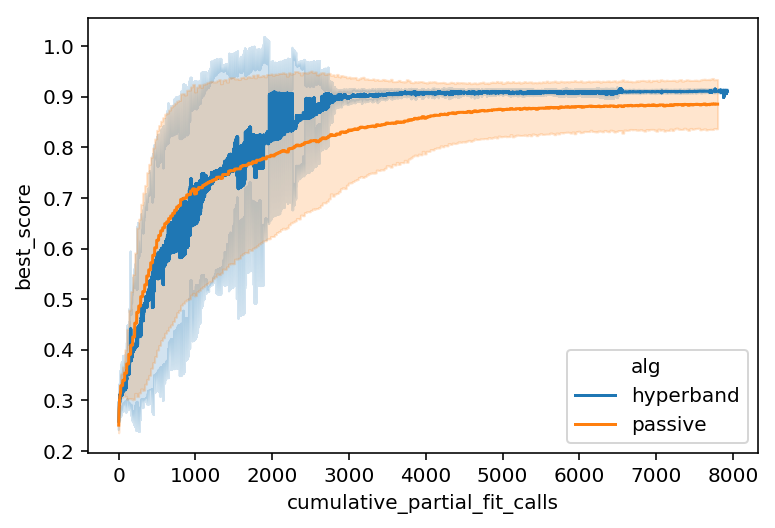

In [24]:
import seaborn as sns
ax = sns.lineplot(
    data=df,
    x="cumulative_partial_fit_calls",
    y="best_score",
    hue="alg",
    ci="sd",
)
# ax.set_ylim(0.5, None)

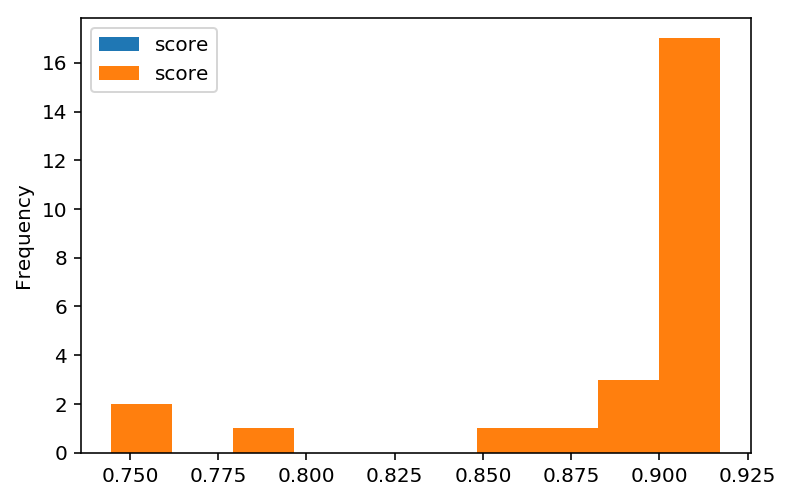

In [25]:
import matplotlib.pyplot as plt
best_scores = [
    {"score": search.best_score_, "alg": alg}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

show = pd.DataFrame(best_scores)
fig, ax = plt.subplots()
for alg in show.alg.unique():
    show[show.alg == alg].plot.hist(ax=ax, label=alg)

In [26]:
params = [
    {"alg": alg, **search.best_params_}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

params = pd.DataFrame(params)
params.drop(
    columns=[
        "n_iter_no_change",
        "activation",
        "nesterovs_momentum",
        "solver"
    ], inplace=True
)
params

,alg,alpha,batch_size,hidden_layer_sizes,learning_rate,learning_rate_init,momentum,power_t
0,hyperband,0.000660,64,"(12, 12)",constant,0.001222,0.875876,0.196096
1,hyperband,0.000007,256,"(24,)",constant,0.006135,0.990991,0.200100
2,hyperband,0.000001,64,"(12, 12)",constant,0.000285,0.980981,0.748649
3,hyperband,0.000380,64,"(12, 12)",constant,0.003627,0.828829,0.657357
4,hyperband,0.000003,64,"(12, 12)",constant,0.003030,0.953954,0.175275
5,hyperband,0.000487,512,"(12, 12)",constant,0.004917,0.982983,0.548448
6,hyperband,0.000769,64,"(12, 6, 3, 3)",constant,0.009908,0.891892,0.272172
7,hyperband,0.000013,32,"(12, 12)",constant,0.006948,0.220220,0.887187
8,hyperband,0.000020,128,"(12, 12)",constant,0.008471,0.542543,0.820721
9,hyperband,0.000004,64,"(12, 12)",constant,0.003217,0.913914,0.627728


In [27]:
best_scores

[{'score': 0.911617676464707, 'alg': 'hyperband'},
 {'score': 0.9072185562887423, 'alg': 'hyperband'},
 {'score': 0.9119176164767047, 'alg': 'hyperband'},
 {'score': 0.9095180963807239, 'alg': 'hyperband'},
 {'score': 0.9134173165366927, 'alg': 'hyperband'},
 {'score': 0.9093181363727254, 'alg': 'hyperband'},
 {'score': 0.9019196160767846, 'alg': 'hyperband'},
 {'score': 0.915116976604679, 'alg': 'hyperband'},
 {'score': 0.9062187562487503, 'alg': 'hyperband'},
 {'score': 0.9092181563687263, 'alg': 'hyperband'},
 {'score': 0.912617476504699, 'alg': 'hyperband'},
 {'score': 0.9130173965206959, 'alg': 'hyperband'},
 {'score': 0.9152169566086783, 'alg': 'hyperband'},
 {'score': 0.9108178364327134, 'alg': 'hyperband'},
 {'score': 0.9123175364927014, 'alg': 'hyperband'},
 {'score': 0.9085182963407319, 'alg': 'hyperband'},
 {'score': 0.9108178364327134, 'alg': 'hyperband'},
 {'score': 0.9090181963607279, 'alg': 'hyperband'},
 {'score': 0.9125174965006999, 'alg': 'hyperband'},
 {'score': 0.91